In [1]:
import pandas as pd
from gensim.corpora.dictionary import Dictionary
from gensim.models import LdaModel
from gensim.test.utils import datapath

import re
import numpy as np
from nltk.corpus import stopwords
from razdel import tokenize 
import pymorphy2  
import nltk

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, roc_auc_score, precision_score, classification_report
from sklearn.metrics import precision_recall_curve, confusion_matrix
import itertools

import matplotlib.pyplot as plt

%matplotlib inline

In [2]:
news = pd.read_csv("articles.csv")
print(news.shape)
news.head(3)

(27000, 2)


,doc_id,title
0,6,Заместитель председателяnправительства РФnСерг...
1,4896,Матч 1/16 финала Кубка России по футболу был п...
2,4897,Форвард «Авангарда» Томаш Заборский прокоммент...


In [3]:
users = pd.read_csv("users_articles.csv")
users.head(3)

,uid,articles
0,u105138,"[293672, 293328, 293001, 293622, 293126, 1852]"
1,u108690,"[3405, 1739, 2972, 1158, 1599, 322665]"
2,u108339,"[1845, 2009, 2356, 1424, 2939, 323389]"


## Получаем векторные представления новостей

In [4]:
nltk.download('stopwords')

stopword_ru = stopwords.words('russian')
len(stopword_ru)

morph = pymorphy2.MorphAnalyzer()

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Pelmellika\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [5]:
with open('stopwords.txt') as f:
    additional_stopwords = [w.strip() for w in f.readlines() if w]
stopword_ru += additional_stopwords
len(stopword_ru)

776

In [6]:
def clean_text(text):
    '''
    очистка текста
    
    на выходе очищеный текст
    
    '''
    if not isinstance(text, str):
        text = str(text)
    
    text = text.lower()
    text = text.strip('\n').strip('\r').strip('\t')
    text = re.sub("-\s\r\n\|-\s\r\n|\r\n", '', str(text))

    text = re.sub("[0-9]|[-—.,:;_%©«»?*!@#№$^•·&()]|[+=]|[[]|[]]|[/]|", '', text)
    text = re.sub(r"\r\n\t|\n|\\s|\r\t|\\n", ' ', text)
    text = re.sub(r'[\xad]|[\s+]', ' ', text.strip())
    
    return text

cache = {}

def lemmatization(text):
    '''
    лемматизация
        [0] если зашел тип не `str` делаем его `str`
        [1] токенизация предложения через razdel
        [2] проверка есть ли в начале слова '-'
        [3] проверка токена с одного символа
        [4] проверка есть ли данное слово в кэше
        [5] лемматизация слова
        [6] проверка на стоп-слова

    на выходе лист отлемматизированых токенов
    '''

    # [0]
    if not isinstance(text, str):
        text = str(text)
    
    # [1]
    tokens = list(tokenize(text))
    words = [_.text for _ in tokens]

    words_lem = []
    for w in words:
        if w[0] == '-': # [2]
            w = w[1:]
        if len(w)>1: # [3]
            if w in cache: # [4]
                words_lem.append(cache[w])
            else: # [5]
                temp_cach = cache[w] = morph.parse(w)[0].normal_form
                words_lem.append(temp_cach)
    
    words_lem_without_stopwords=[i for i in words_lem if not i in stopword_ru] # [6]
    
    return words_lem_without_stopwords

In [7]:
%%time
#Очистка текста
news['title'] = news['title'].apply(lambda x: clean_text(x), 1)

<ipython-input-6-2b1de38ed3a9>:15: FutureWarning: Possible nested set at position 39
  text = re.sub("[0-9]|[-—.,:;_%©«»?*!@#№$^•·&()]|[+=]|[[]|[]]|[/]|", '', text)


Wall time: 28.1 s


In [8]:
%%time
#Лемматизация текста
news['title'] = news['title'].apply(lambda x: lemmatization(x), 1)

Wall time: 4min 3s


In [9]:
news['title']

0        [заместитель, председатель, правительство, рф,...
1        [матч, финал, кубок, россия, футбол, приостано...
2        [форвард, авангард, томаш, заборский, прокомме...
3        [главный, тренер, кубань, юрий, красножанин, п...
4        [решение, попечительский, совет, владивостокск...
                               ...                        
26995    [учёный, токийский, университет, морской, наук...
26996    [глава, кафедра, отечественный, история, xx, в...
26997    [американский, учёный, уточнить, возраст, расп...
26998    [последний, год, тропический, углеродный, цикл...
26999    [жить, примерно, тыс, год, назад, территория, ...
Name: title, Length: 27000, dtype: object

In [10]:
#сформируем список наших текстов, разбив еще и на пробелы
texts = [t for t in news['title'].values]

# Create a corpus from a list of texts
common_dictionary = Dictionary(texts)
common_corpus = [common_dictionary.doc2bow(text) for text in texts]

## Обучение

In [11]:
%%time
# Train the model on the corpus.
lda = LdaModel(common_corpus, num_topics=25, id2word=common_dictionary)#, passes=10)

Wall time: 42.2 s


In [12]:
# Save model to disk.
temp_file = datapath("model.lda")
lda.save(temp_file)

# Load a potentially pretrained model from disk.
lda = LdaModel.load(temp_file)

In [13]:
# Create a new corpus, made of previously unseen documents.
other_texts = [t for t in news['title'].iloc[:3]]
other_corpus = [common_dictionary.doc2bow(text) for text in other_texts]

unseen_doc = other_corpus[2]
print(other_texts[2])
lda[unseen_doc] 

['форвард', 'авангард', 'томаш', 'заборский', 'прокомментировать', 'игра', 'свой', 'команда', 'матч', 'чемпионат', 'кхл', 'против', 'атланта', 'nnnn', 'провести', 'плохой', 'матч', 'нижний', 'новгород', 'против', 'торпедо', 'настраиваться', 'первый', 'минута', 'включиться', 'работа', 'сказать', 'заборский', 'получиться', 'забросить', 'быстрый', 'гол', 'задать', 'хороший', 'темп', 'поединок', 'мочь', 'играть', 'ещё', 'хороший', 'сторона', 'пять', 'очко', 'выезд', 'девять', 'это', 'хороший']


[(4, 0.5337977), (13, 0.26765287), (18, 0.12513678), (21, 0.054584857)]

In [14]:
x=lda.show_topics(num_topics=25, num_words=7,formatted=False)
topics_words = [(tp[0], [wd[0] for wd in tp[1]]) for tp in x]

#Below Code Prints Only Words 
for topic,words in topics_words:
    print("topic_{}: ".format(topic)+" ".join(words))

topic_0: год это цена который рост мочь риск
topic_1: парка австрийский баку осторожный аккуратно сантиметр комар
topic_2: исследование земля это мочь который пациент случай
topic_3: украина банк украинский год компания продукция nn
topic_4: год напомнить хороший nn фрагмент возраст опрос
topic_5: год это который новый мочь страна россия
topic_6: год рубль млн гражданин суд который компания
topic_7: рейс операция лётчик пилот армения французский франция
topic_8: год который россия это человек данные страна
topic_9: запуск энергия определение подсчитать кг сон су
topic_10: проверка журнал рейтинг виза характерный клинический полоса
topic_11: ми новак эндрю соль трансляция русло урегулировать
topic_12: год ракета журнал вода планета экипаж исследование
topic_13: человек это который год весь свой всё
topic_14: погибнуть взрыв миссия километр турецкий восточный террорист
topic_15: дело мужчина суд женщина убийство задержать сотрудник
topic_16: станция научный университет это который год те

In [15]:
# Функция, возвращающая векторное представление новости
def get_lda_vector(text):
    unseen_doc = common_dictionary.doc2bow(text)
    lda_tuple = lda[unseen_doc]
    not_null_topics = dict(zip([i[0] for i in lda_tuple], [i[1] for i in lda_tuple]))

    output_vector = []
    for i in range(25):
        if i not in not_null_topics:
            output_vector.append(0)
        else:
            output_vector.append(not_null_topics[i])
    return np.array(output_vector)

In [16]:
topic_matrix = pd.DataFrame([get_lda_vector(text) for text in news['title'].values])
topic_matrix.columns = ['topic_{}'.format(i) for i in range(25)]
topic_matrix['doc_id'] = news['doc_id'].values
topic_matrix = topic_matrix[['doc_id']+['topic_{}'.format(i) for i in range(25)]]
topic_matrix.head(5)

,doc_id,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,...,topic_15,topic_16,topic_17,topic_18,topic_19,topic_20,topic_21,topic_22,topic_23,topic_24
0,6,0.0,0.0,0.0,0.853361,0.046461,0.0,0.0,0.0,0.0,...,0.073645,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0
1,4896,0.0,0.0,0.0,0.000000,0.250943,0.0,0.0,0.0,0.0,...,0.096916,0.0,0.140916,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0
2,4897,0.0,0.0,0.0,0.000000,0.533893,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.000000,0.125146,0.0,0.0,0.054586,0.0,0.0,0.0
3,4898,0.0,0.0,0.0,0.365189,0.215267,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0
4,4899,0.0,0.0,0.0,0.845276,0.101038,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0


## Получение векторных представлений пользователей

In [17]:
doc_dict = dict(zip(topic_matrix['doc_id'].values, topic_matrix[['topic_{}'.format(i) for i in range(25)]].values))

In [18]:
target = pd.read_csv("users_churn.csv")
target.head(3)

,uid,churn
0,u107120,0
1,u102277,0
2,u102444,0


In [19]:
user_articles_list = users['articles'].iloc[33]

def get_user_embedding(user_articles_list, aggregation):
    user_articles_list = eval(user_articles_list)
    user_vector = np.array([doc_dict[doc_id] for doc_id in user_articles_list])
    if aggregation == 'mean':
        user_vector = np.mean(user_vector, 0)
    elif aggregation == 'median':
        user_vector = np.median(user_vector, 0)
    elif aggregation == 'max':
        user_vector = np.max(user_vector, 0)
    return user_vector

In [20]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

<ipython-input-21-b1bbc5abdefa>:23: RuntimeWarning: invalid value encountered in true_divide
  fscore = (2 * precision * recall) / (precision + recall)


Function aggregation: mean
Best Threshold=0.779866, F-Score=nan, Precision=0.000, Recall=0.000
roc_auc_score: 0.9483946741089598

Confusion matrix, without normalization
[[1755    0]
 [ 245    0]]


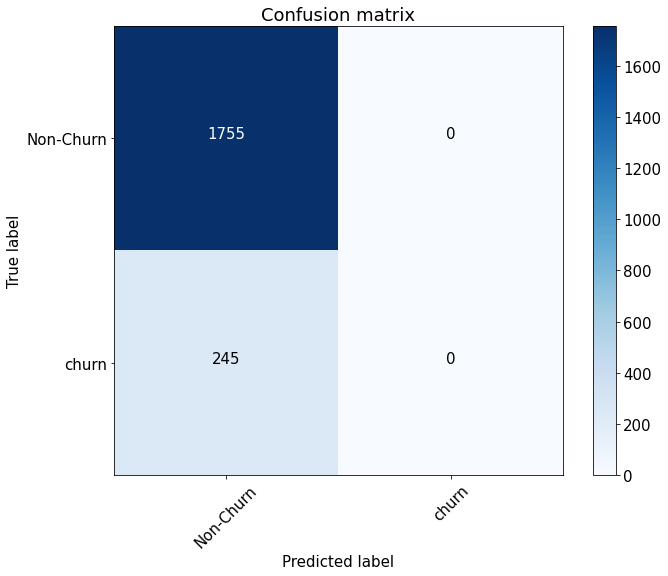

Function aggregation: median
Best Threshold=0.264689, F-Score=0.778, Precision=0.743, Recall=0.816
roc_auc_score: 0.9726751555322983

Confusion matrix, without normalization
[[1686   69]
 [  46  199]]


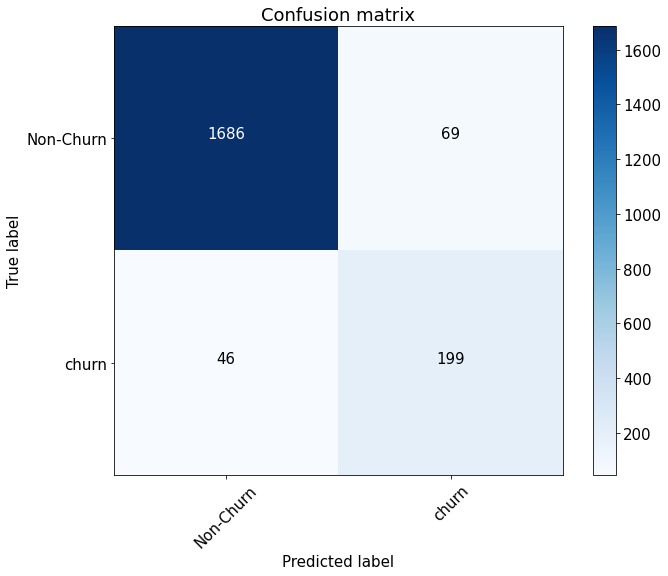

Function aggregation: max
Best Threshold=0.326512, F-Score=0.806, Precision=0.782, Recall=0.833
roc_auc_score: 0.9757776614919471

Confusion matrix, without normalization
[[1698   57]
 [  42  203]]


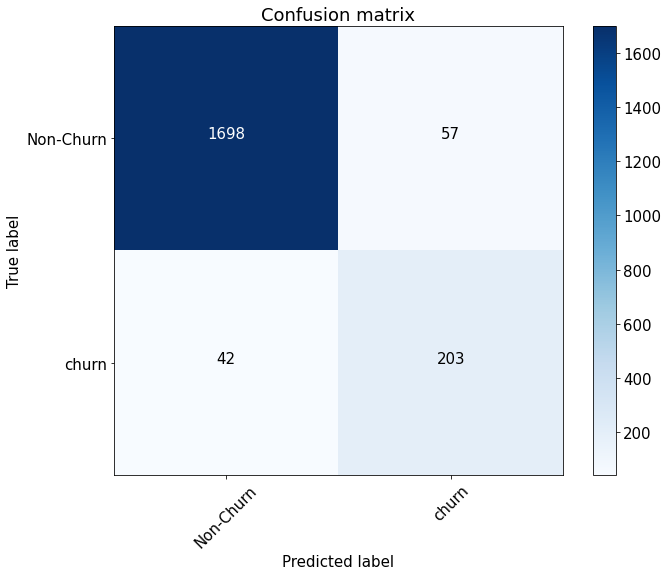

In [21]:
list_aggregation = ['mean', 'median', 'max']
list_precision = []
list_recall = []
list_f_score = []
list_roc_auc = []
for aggregation in list_aggregation:
    list_aggregation
    user_embeddings = pd.DataFrame([i for i in users['articles'].apply(lambda x: get_user_embedding(x, aggregation), 1)])
    user_embeddings.columns = ['topic_{}'.format(i) for i in range(25)]
    user_embeddings['uid'] = users['uid'].values
    user_embeddings = user_embeddings[['uid']+['topic_{}'.format(i) for i in range(25)]]
    X = pd.merge(user_embeddings, target, 'left')
    #разделим данные на train/test
    X_train, X_test, y_train, y_test = train_test_split(X[['topic_{}'.format(i) for i in range(25)]], 
                                                    X['churn'], random_state=0)
    logreg = LogisticRegression()
    #обучим модель
    logreg.fit(X_train, y_train)
    #получим прогнозы для тестовой выборки
    preds = logreg.predict_proba(X_test)[:, 1]
    # расчёт метрик: Precision, Recall, F_score
    precision, recall, thresholds = precision_recall_curve(y_test, preds)
    fscore = (2 * precision * recall) / (precision + recall)
    # locate the index of the largest f score
    ix = np.argmax(fscore)
    print('Function aggregation:', aggregation)
    print('Best Threshold=%f, F-Score=%.3f, Precision=%.3f, Recall=%.3f' % (thresholds[ix], 
                                                                        fscore[ix],
                                                                        precision[ix],
                                                                        recall[ix]))
    list_precision.append(precision[ix])
    list_recall.append(recall[ix])
    list_f_score.append(fscore[ix])
    list_roc_auc.append(roc_auc_score(y_test, preds))
    print('roc_auc_score:', roc_auc_score(y_test, preds))
    print()
    # построение confusion matrix
    font = {'size' : 15}

    plt.rc('font', **font)

    cnf_matrix = confusion_matrix(y_test, preds>thresholds[ix])
    plt.figure(figsize=(10, 8))
    plot_confusion_matrix(cnf_matrix, classes=['Non-Churn', 'churn'],
                      title='Confusion matrix')
    plt.show()

In [22]:
result = pd.DataFrame()

In [23]:
result['Aggregation_method'] = list_aggregation
result['Precision'] = list_precision
result['Recall'] = list_recall
result['F_score'] = list_f_score
result['ROC_AUC'] = list_roc_auc

In [24]:
result = result.reset_index(drop=True)

In [25]:
result

,Aggregation_method,Precision,Recall,F_score,ROC_AUC
0,mean,0.000000,0.000000,NaN,0.948395
1,median,0.743494,0.816327,0.778210,0.972675
2,max,0.781609,0.832653,0.806324,0.975778


Выводы:
1. Наиболее точные результаты показывает метод "max" для получения эмбедингов пользователей
2. Использование максимума в качестве агрегирующей функции позволяет получить более точный результат, т.к. выдаёт более высокие значения для векторного представления пользователей и документов. Встречающиеся слова довольно разнообразны, поэтому в ходе решения при создании матрицы происходит искусственное добавление большого числа нулей, из-за чего при усреднении векторные представления уменьшаются , а медианное значение очень часто получается равно нулю.